In [1]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0,1,1,2],
                           [1,0,2,1]]).long()
x = torch.tensor([[-1],[0],[1]]).float()

data = Data(x=x, edge_index=edge_index)

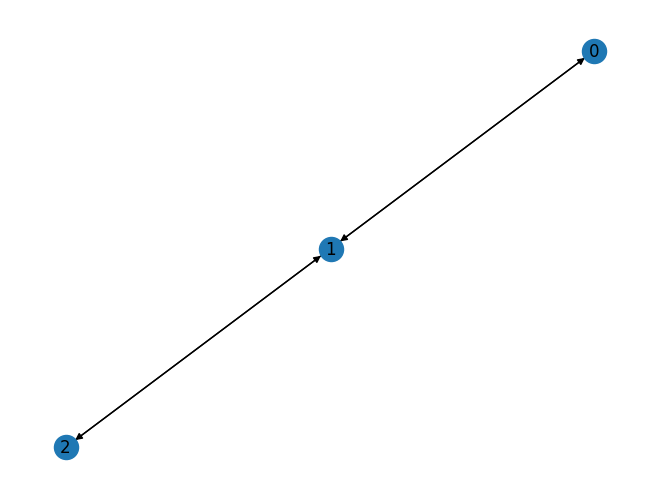

In [2]:
import torch_geometric.utils as pyg_utils
import networkx as nx
def draw_data(data:Data,to_undirected=False):
    nx_g = pyg_utils.to_networkx(data,to_undirected=to_undirected)
    nx.draw(nx_g,with_labels = True)
draw_data(data)

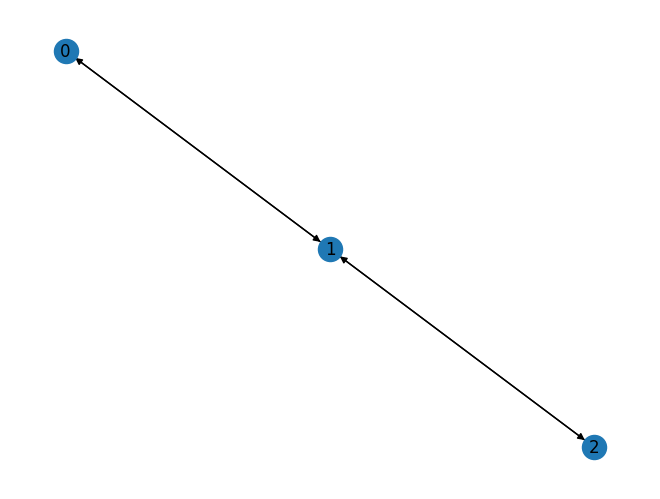

In [3]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.transpose(0,1))
draw_data(data)

In [4]:
'https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data'
print(data.keys)
print(data.x)
print(data.edge_index)

['x', 'edge_index']
tensor([[-1.],
        [ 0.],
        [ 1.]])
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [5]:
print('node')
print(data.num_nodes)
print(data.num_node_features)
print(data.num_node_types)

node
3
1
1


In [6]:
print('edge')
print(data.num_edges)
print(data.num_edge_features)
print(data.num_edge_types)

edge
4
0
1


In [7]:
print('graph')
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_directed())

graph
False
False
False


In [8]:
for key,item in data:
    print(key,item)

x tensor([[-1.],
        [ 0.],
        [ 1.]])
edge_index tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [9]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
{
    'graph number': len(dataset),
    'num_classes': dataset.num_classes,
    'num_node_features': dataset.num_node_features
}

{'graph number': 600, 'num_classes': 6, 'num_node_features': 3}

In [10]:
data = dataset[0]
data

Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [11]:
dataset = dataset.shuffle()
train_dataset = dataset[:540]
test_dataset = dataset[540:]

# Train GCN Classifier

In [12]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/data/Cora', name='Cora')
{
    'graph number': len(dataset),
    'num_classes': dataset.num_classes,
    'num_node_features': dataset.num_node_features
}

{'graph number': 1, 'num_classes': 7, 'num_node_features': 1433}

In [13]:
data = dataset[0]
print(data)
{
    'is_directed':data.is_undirected(),
    'train size' : data.train_mask.sum().item(),
    'val size' : data.val_mask.sum().item(),
    'test size': data.test_mask.sum().item()
}

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


{'is_directed': True, 'train size': 140, 'val size': 500, 'test size': 1000}

In [14]:
nx.write_gexf(pyg_utils.to_networkx(data),"./save_results/tmp.gexf")

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

class GCN(nn.Module):
    def __init__(self,seed=42):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = pyg_nn.GCNConv(dataset.num_node_features, 16)
        self.conv2 = pyg_nn.GCNConv(16, dataset.num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

In [16]:
def plot_loss(hist):
    import matplotlib.pyplot as plt
    plt.title(f'epoch - {len(hist["train"])}')
    plt.plot(hist['train'],label='train')
    plt.plot(hist['test'],label='test')
    plt.legend()
    plt.show()

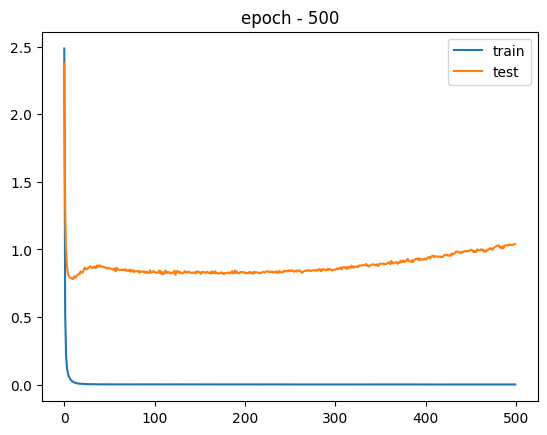

Accuracy: 0.6950


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

def train(model,optimizer,n = 100):
    
    hist = {'train':[],'test':[]}
    for epoch in range(n):
        model.train()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        hist['train'].append(loss.item())
        
        loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
        hist['test'].append(loss.item())
    
    plot_loss(hist)
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')

model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train(model,optimizer,500)

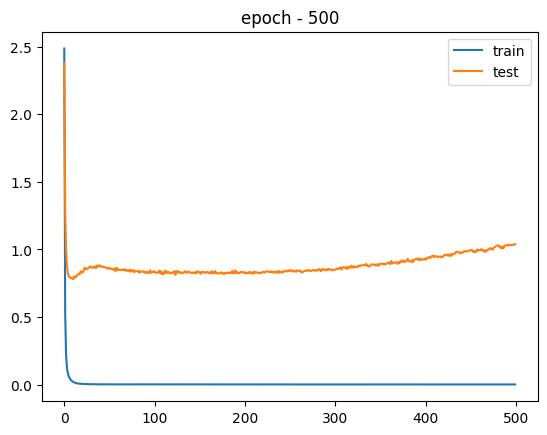

Accuracy: 0.6970


In [18]:
class GCN(nn.Module):
    def __init__(self,seed=42):
        super(GCN,self).__init__()
        torch.manual_seed(seed)
        def GCN_block(in_channels,out_channels):
            return (
                (pyg_nn.GCNConv(in_channels,out_channels), 'x,edge_index -> x'),
                (nn.ReLU(), 'x -> x'),
                (pyg_nn.BatchNorm(out_channels), 'x -> x'),
                (nn.Dropout(0.1), 'x -> x'),)
        
        self.conv = pyg_nn.Sequential('x,edge_index',[
            *GCN_block(dataset.num_node_features,32),
            (pyg_nn.GCNConv(32, dataset.num_classes), 'x,edge_index -> x'),
            (nn.LogSoftmax(dim=1), 'x -> x'),
        ])

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x,edge_index)
        return x
    
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train(model,optimizer,500)